In [1]:
from skimage.filters import unsharp_mask
from skimage import color
from skimage.transform import resize
import numpy as np
import torch 
import glob
import matplotlib.pyplot as plt
import skimage.exposure as exposure
import time
import preprocessor
import models
import torch_models
import visualize
import timer
import random
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
np.set_printoptions(suppress=True)

### Prepocessing 
- Take images and resize to $128 \times 128 $
- <font color='red'> Note resizing degrades picture quality meaning some details lost which affects model accuracy.

#### Image enhancement
To enhance the details in the resized images the following techniques are used
- unsharp masking (sharpens the image)
- histogram equalization (improves image contrast)

In [2]:
n_rows , n_cols = 128,128

Text(0.5, 1.0, 'Resized')

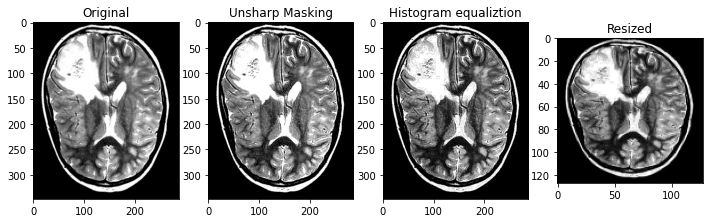

In [3]:
img = plt.imread('raw_data/samples/y0.jpg')
img_sharpened = unsharp_mask(img[:,:,0],amount=1,radius=1)
img_equalized = exposure.equalize_hist(img_sharpened,nbins=256)
resized = resize(img_equalized,(n_rows,n_cols),anti_aliasing=True)
fig,ax = plt.subplots(1,4,figsize=(12,6))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(img_sharpened,cmap='gray')
ax[1].set_title('Unsharp Masking')
ax[2].imshow(img_equalized,cmap='gray')
ax[2].set_title('Histogram equaliztion')
ax[3].imshow(resized,cmap='gray')
ax[3].set_title('Resized')

# Loading training & testing data

- Class encodings
 - 0 : no brain tumor
 - 1: brain tumor


In [4]:
# load data
def load_data(path):
    # get filenames and total
    no_files = glob.glob('data/'+path+'/no/*.jpg')
    yes_files = glob.glob('data/'+path+'/yes/*.jpg')
    total=len(no_files)+len(yes_files)
    
    #arrays to store data
    x=np.ones((total,n_rows*n_cols))
    y=np.ones((total,))
    
    #load no tumor images belonging to class 0
    i=0
    for filename in no_files:
        image=plt.imread(filename)
        if image.ndim>2:
            image=image[:,:,0]
        x[i,:]=image.flatten()
        y[i]=0
        i=i+1
    
    #load tumor images belonging to class 1
    for filename in yes_files:
        image=plt.imread(filename)
        if image.ndim>2:
            image=image[:,:,0]
        x[i,:]=image.flatten()
        y[i]=1
        i=i+1

    idx=np.arange(len(x))
    np.random.shuffle(idx)
    x=x[idx]
    y=y[idx]
    return x,y

# convert a flattened array back to image
def vec_to_image(v):
    img = v.reshape(n_rows,n_cols)
    return img


In [5]:
x_train,y_train = load_data("training")
x_test,y_test = load_data("testing")
# np.unique(y_train,return_counts=True)

### Sample Images

Text(0.5, 1.0, 'Brain Cancer MRI')

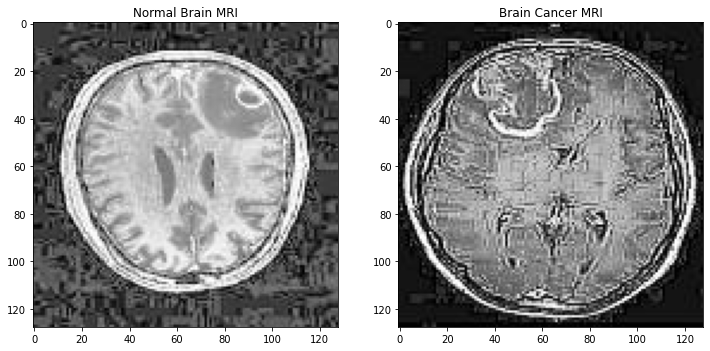

In [6]:
normal_img_idx = np.where(y_train==0)[0]
abnormal_img_idx = np.where(y_train==1)[0]
normal_img = vec_to_image(x_train[normal_img_idx[-1]])
abnormal_img = vec_to_image(x_train[abnormal_img_idx[-1]])
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(normal_img,cmap='gray')
ax[0].set_title('Normal Brain MRI')
ax[1].imshow(abnormal_img,cmap='gray')
ax[1].set_title('Brain Cancer MRI')

### Feature scalling

In [7]:
scaler = preprocessor.DataPreprocessor(x_train)
x_train_n = scaler.fit_transform(x_train,'s')
x_test_n = scaler.fit_transform(x_test,'s')

### Perfomance test (CPU vs GPU) 
The main goal is to check the performance improvements that can be achieved by implementing a model (Logistic Regression) on the gpu instead of the cpu. The implemented model uses gradient descent based learning, this is where the computation is done during training to find optimal weights. The cpu implementation relies solely in numpy while the gpu implementation relies on torch. To gauge the 2 implementations the following experiments are conducted

- (Gradient descent based learning) vary the number of iterations used in learning and measure the computation time
taken to fininsh weight updates

Note: Any relevant model hyperparameters such as the learning rate or regularization strength are kept constant and have the following values
- learning rate $\alpha = 0.1$
- regularization $\gamma = 0.0001$

In [8]:
def run_experiment(n_experiments,params,gpu_model,cpu_model):
    runner = timer.Timer(gpu_model,cpu_model)
    gpu_results,cpu_results = runner.experiment(n_experiments,x_train_n,y_train,params)
    return gpu_results,cpu_results

def make_experiment(n_experiments,params,gpu_model,cpu_model,values,metric='t_max'):
    gpu_data = []
    cpu_data = []
    if metric=='t_max':
        for t_max in values: 
            params['t_max'] = t_max
            gpu_results,cpu_results = run_experiment(n_experiments,params,gpu_model,cpu_model)
            gpu_data.append(gpu_results)
            cpu_data.append(cpu_results)
        return gpu_data,cpu_data
    
    elif metric=='batch_size':
        for batch_size in values: 
            params['batch_size'] = batch_size
            gpu_results,cpu_results = run_experiment(n_experiments,params,gpu_model,cpu_model)
            gpu_data.append(gpu_results)
            cpu_data.append(cpu_results)
        return gpu_data,cpu_data
        
def experiment_results(gpu_results,cpu_results,metric):
    n = len(gpu_results)
    y_gpu = np.zeros(n)
    y_cpu = np.zeros(n)
    for i in range(n):
        gpu_data = gpu_results[i]
        cpu_data = cpu_results[i]
        y_gpu[i] = gpu_data[metric]
        y_cpu[i] = cpu_data[metric]
    
    return y_gpu,y_cpu
    

In [9]:
gpu_lr = torch_models.LogisticRegression(x_train_n,y_train)
cpu_lr = models.LogisticRegression(x_train_n,y_train)

### Perfomance test (Varying Iterations)
We vary the number of iterations for batch gradient descent learning from $[10,40]$ in steps of $10$. Each experiment is run 4 times and the avarage result is taken. We then plot the running time of each algorithm
on different set of axes and also the ratio of the 2 curves.
  - $x$ axis (number of iterations)
  - $y$  axis time taken to finish weight updates

In [10]:
model_params = {'mode':'bgd','t_max':10,'alpha':0.1,'gamma':0.0001,'epsilon':0}
n_experiments = 4

In [11]:
t_values = [10,20,30,40]
gpu_results,cpu_results = make_experiment(n_experiments,model_params,gpu_lr,cpu_lr,t_values)

/home/phantom/Documents/Projects/Personal/Brain-Tumor-Detection/models.py:15: RuntimeWarning: overflow encountered in exp
  y = 1/(1+np.exp(-z))


In [12]:
y_gpu,y_cpu = experiment_results(gpu_results,cpu_results,metric='average_training_time')

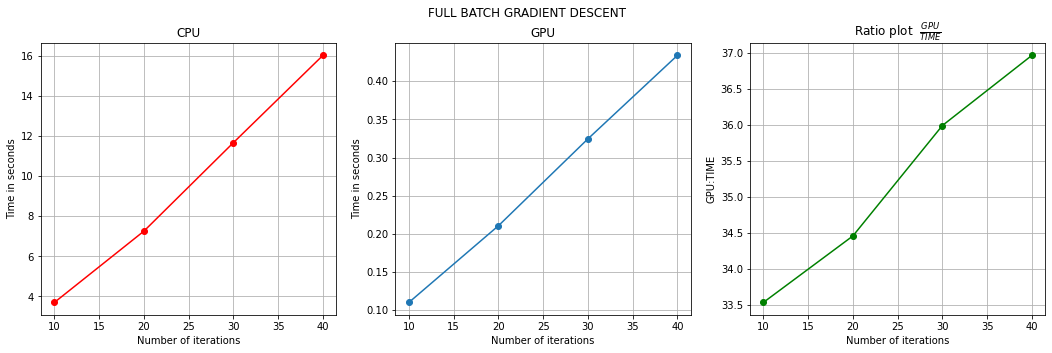

In [13]:
fig,ax = plt.subplots(1,3,figsize=(18,5))
fig.suptitle('FULL BATCH GRADIENT DESCENT')
ax[0].set_title('CPU')
ax[0].set_xlabel('Number of iterations')
ax[0].set_ylabel('Time in seconds')
ax[0].plot(t_values,y_cpu,marker='o',color='red')
ax[0].grid()
ax[1].plot(t_values,y_gpu,marker='o')
ax[1].set_title('GPU')
ax[1].set_xlabel('Number of iterations')
ax[1].set_ylabel('Time in seconds')
ax[1].grid()
ax[2].plot(t_values,y_cpu/y_gpu,marker='o',color='green')
ax[2].set_title(r'Ratio plot  $\frac{{GPU}}{{TIME}}$'.format(1,2))
ax[2].set_xlabel('Number of iterations')
ax[2].set_ylabel('GPU:TIME')
ax[2].grid()
plt.savefig('figures/runtime.png')

### <font color="red"> Note <fonr/>
We note that from the curves above it is clear that the gpu far out performs the cpu implementation achieving improvements of up to $36\times cpu_{speed}$

### Model Fitting
We fitting our logistig regression model (GPU) and evaluate its perfomance
- learning rate $\alpha=0.3$
- regularization strength $\gamma= 0.01$
- max iterations $t_{max} = 100$

In [32]:
alpha = 0.2 # learning rate
gamma = 0.01 # regularization strngeth
epsilon = 1e-3 # tolerance
batch_size = 1024 # nano
t_max = 500 # maximum iterations

Random parameters training accuracy 53.935418768920286 %
Learning time 1.8643274307250977 seconds
Training accuracy: 99.2936427850656 %
Testing accuracy: 88.5 %



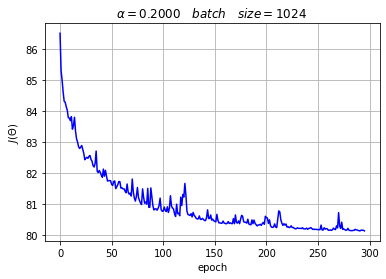

In [33]:
del gpu_lr
torch.cuda.empty_cache()
gpu_lr = torch_models.LogisticRegression(x_train_n,y_train)
print("Random parameters training accuracy",gpu_lr.score(x_train_n,y_train),"%")
start=time.time()
theta,J = gpu_lr.train(mode="mbgd",alpha=alpha,epsilon=epsilon,gamma=gamma,t_max=t_max)
end=time.time()
print("Learning time",end-start,"seconds")
print("Training accuracy:",gpu_lr.score(x_train_n,y_train),"%")
print("Testing accuracy:",gpu_lr.score(x_test_n,y_test),"%\n")
title = r'$\alpha={:.4f} \quad batch \quad size ={:d} $ '.format(alpha,batch_size)
visualize.cost_curve(J,title,'epoch','b')